<a href="https://colab.research.google.com/github/husaintheking/CMLS1/blob/main/CMLSHW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***LIB IMPORT***



In [ ]:
from pathlib import Path
import pandas as pd

import numpy as np
from numpy.fft import rfft, irfft
from numpy import argmax, sqrt, mean, absolute, arange, log10

#from __future__ import division
import sys

import scipy as sp
import scipy.stats
from scipy.signal import blackmanharris, flattop, hilbert


import librosa

%matplotlib inline
import os
import matplotlib.pyplot as plt
import IPython.display as ipd

import sklearn
from sklearn.mixture import BayesianGaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2
from sklearn.pipeline import Pipeline

import seaborn as sns

from keras import models, layers

## ***Path***

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
%cd "\Users\Axel\Desktop\AudioProve"
%ls

C:\Users\Axel\Desktop\AudioProve
 Il volume nell'unit… C Š Windows
 Numero di serie del volume: 3005-71E3

 Directory di C:\Users\Axel\Desktop\AudioProve

18/04/2021  12:34    <DIR>          .
18/04/2021  12:34    <DIR>          ..
25/04/2021  18:54    <DIR>          Distortion
16/04/2021  18:20    <DIR>          NoFX
25/04/2021  18:55    <DIR>          Tremolo
               0 File              0 byte
               5 Directory  688.862.490.624 byte disponibili


# ***FEATURES FUNCTIONS***

## ***Envelope Flatness***

In [ ]:
def env_flatness(signal):

  z = hilbert(signal) #form the analytical signal
  env = np.abs(z) #envelope extraction
  norm = env.mean(axis=0, keepdims=True)
  env = np.log(np.abs(env) + 1e-20)
  flat = np.exp(env.mean(axis=0, keepdims=True)) / norm

  return flat

## ***THDN***

In [ ]:
def rms(a):
    """
    Return the root mean square of all the elements of *a*, flattened out.
    """
    return sqrt(mean(a**2))


def find_range(f, x):
    """
    Find range between nearest local minima from peak at index x
    """
    for i in arange(x+1, len(f)):
        if f[i+1] >= f[i]:
            uppermin = i
            break
    for i in arange(x-1, 0, -1):
        if f[i] <= f[i-1]:
            lowermin = i + 1
            break
    return (lowermin, uppermin)


def compute_THDN(signal, sample_rate):
    """˙
    Measure the THD+N for a signal and print the results
    Prints the estimated fundamental frequency and the measured THD+N.  This is
    calculated from the ratio of the entire signal before and after
    notch-filtering.
    Currently this tries to find the "skirt" around the fundamental and notch
    out the entire thing.  A fixed-width filter would probably be just as good,
    if not better.
    """
    # Get rid of DC and window the signal

    # TODO: Do this in the frequency domain, and take any skirts with it?
    signal -= mean(signal)
    windowed = signal * blackmanharris(len(signal))
    #windowed = signal * flattop(len(signal)) 

    # Measure the total signal before filtering but after windowing
    total_rms = rms(windowed)

    # Find the peak of the frequency spectrum (fundamental frequency), and
    # filter the signal by throwing away values between the nearest local
    # minima
    f = rfft(windowed)
    i = argmax(abs(f))

    # Not exact
    #print('Frequency: %f Hz' % (sample_rate * (i / len(windowed))))
    lowermin, uppermin = find_range(abs(f), i)
    f[lowermin: uppermin] = 0

    # Transform noise + harmonics back into the signal domain and measure it
    noise = irfft(f)
    THDN = rms(noise) / total_rms

    #print("THD+N:     %.4f%% or %.1f dB" % (THDN * 100, 20 * log10(THDN)))

    return THDN


# ***FOLDERS CREATION***

In [ ]:
file_root = '/Users/Axel/Desktop/AudioProve'

# Function that creates a data frame form a given directory
def create_dataFrame(dirName):
    # dictionaries representing each class
    MyFolders = {'Distortion': [], 'NoFX': [], 'Tremolo': []}
    training_folders = {'Distortion': [], 'NoFX': [], 'Tremolo': []}
    testing_folders = {'Distortion': [], 'NoFX': [], 'Tremolo': []}

    Roots = os.listdir(dirName)
    for e, entry in enumerate(Roots):
            # Create full path to sub-directory
            if os.path.isdir(entry):
              print(e, entry)
              fullPath = os.path.join(dirName, entry)
              listOfFiles = list();
              Files = list();
              for (dirpath, dirnames, filenames) in os.walk(fullPath):
                      # Create the full path for each file in the sub-directory and put them in a list
                      listOfFiles = [os.path.join(dirpath, file) for file in filenames] 

                      # Take the files base names only (for visualization)
                      Files = [os.path.basename(file) for file in listOfFiles]

                      # Training and Testing files separation for each class
                      train, test = train_test_split(listOfFiles, test_size=0.25, random_state=42, shuffle=True)
                      #print(len(train))

              # Put the files in a dictionary

              MyFolders[entry] = Files

              training_folders[entry] = train
              testing_folders[entry] = test

    # Create a data frame from the dictionary (for visualization)
    pd.set_option('display.max_columns', None, 'display.max_rows', None)  # DISPLAY THE WHOLE FRAME

    dict_df = pd.DataFrame({ key:pd.Series(value) for key, value in MyFolders.items() })

    train_dict = pd.DataFrame({ key:pd.Series(value) for key, value in training_folders.items() })
    test_dict = pd.DataFrame({ key:pd.Series(value) for key, value in testing_folders.items() })

    return dict_df, train_dict, test_dict

In [ ]:
# CREAZIONE DEI 3 DATAFRAME RISPETTIVAMENTE L'INTERA CARTELLA DEI FILES, LA CARTELLA DEI FILES PER IL TRAINING E LA CARTELLA DEI FILES PER IL TESTING
[df, train, test] = create_dataFrame(file_root)

0 Distortion
1 NoFX
2 Tremolo


In [ ]:
# L'INTERA CARTELLA DEI FILES
df

,Distortion,NoFX,Tremolo
0,G83-54209-4411-37853.wav,G61-40100-1111-20593.wav,G83-54209-3341-34109.wav
1,G83-54209-4412-38477.wav,G61-41101-1111-20594.wav,G83-54209-3342-34733.wav
2,G83-54209-4413-39101.wav,G61-42102-1111-20595.wav,G83-54209-3343-35357.wav
3,G83-54304-4411-37861.wav,G61-43103-1111-20596.wav,G83-54304-3341-34117.wav
4,G83-54304-4412-38485.wav,G61-44104-1111-20597.wav,G83-54304-3342-34741.wav
5,G83-54304-4413-39109.wav,G61-45105-1111-20598.wav,G83-54304-3343-35365.wav
6,G83-55210-4411-37854.wav,G61-45200-1111-20606.wav,G83-55210-3341-34110.wav
7,G83-55210-4412-38478.wav,G61-46106-1111-20599.wav,G83-55210-3342-34734.wav
8,G83-55210-4413-39102.wav,G61-46201-1111-20607.wav,G83-55210-3343-35358.wav
9,G83-55305-4411-37862.wav,G61-47107-1111-20600.wav,G83-55305-3341-34118.wav


In [ ]:
# I FILES PER IL TRAINING
train

,Distortion,NoFX,Tremolo
0,/Users/Axel/Desktop/AudioProve\Distortion\G93-...,/Users/Axel/Desktop/AudioProve\NoFX\G93-60405-...,/Users/Axel/Desktop/AudioProve\Tremolo\G93-686...
1,/Users/Axel/Desktop/AudioProve\Distortion\G91-...,/Users/Axel/Desktop/AudioProve\NoFX\G73-70606-...,/Users/Axel/Desktop/AudioProve\Tremolo\G91-624...
2,/Users/Axel/Desktop/AudioProve\Distortion\G91-...,/Users/Axel/Desktop/AudioProve\NoFX\G71-47107-...,/Users/Axel/Desktop/AudioProve\Tremolo\G91-431...
3,/Users/Axel/Desktop/AudioProve\Distortion\G93-...,/Users/Axel/Desktop/AudioProve\NoFX\G83-74610-...,/Users/Axel/Desktop/AudioProve\Tremolo\G93-533...
4,/Users/Axel/Desktop/AudioProve\Distortion\G91-...,/Users/Axel/Desktop/AudioProve\NoFX\G81-52302-...,/Users/Axel/Desktop/AudioProve\Tremolo\G91-664...
5,/Users/Axel/Desktop/AudioProve\Distortion\G91-...,/Users/Axel/Desktop/AudioProve\NoFX\G71-65506-...,/Users/Axel/Desktop/AudioProve\Tremolo\G91-512...
6,/Users/Axel/Desktop/AudioProve\Distortion\G83-...,/Users/Axel/Desktop/AudioProve\NoFX\G63-66411-...,/Users/Axel/Desktop/AudioProve\Tremolo\G83-715...
7,/Users/Axel/Desktop/AudioProve\Distortion\G93-...,/Users/Axel/Desktop/AudioProve\NoFX\G83-47107-...,/Users/Axel/Desktop/AudioProve\Tremolo\G93-431...
8,/Users/Axel/Desktop/AudioProve\Distortion\G93-...,/Users/Axel/Desktop/AudioProve\NoFX\G93-66411-...,/Users/Axel/Desktop/AudioProve\Tremolo\G93-715...
9,/Users/Axel/Desktop/AudioProve\Distortion\G91-...,/Users/Axel/Desktop/AudioProve\NoFX\G71-51301-...,/Users/Axel/Desktop/AudioProve\Tremolo\G91-452...


In [ ]:
# I FILES PER IL TESTING
test

,Distortion,NoFX,Tremolo
0,/Users/Axel/Desktop/AudioProve\Distortion\G93-...,/Users/Axel/Desktop/AudioProve\NoFX\G83-65410-...,/Users/Axel/Desktop/AudioProve\Tremolo\G93-511...
1,/Users/Axel/Desktop/AudioProve\Distortion\G93-...,/Users/Axel/Desktop/AudioProve\NoFX\G91-55210-...,/Users/Axel/Desktop/AudioProve\Tremolo\G93-573...
2,/Users/Axel/Desktop/AudioProve\Distortion\G91-...,/Users/Axel/Desktop/AudioProve\NoFX\G71-66411-...,/Users/Axel/Desktop/AudioProve\Tremolo\G91-512...
3,/Users/Axel/Desktop/AudioProve\Distortion\G91-...,/Users/Axel/Desktop/AudioProve\NoFX\G71-65410-...,/Users/Axel/Desktop/AudioProve\Tremolo\G91-511...
4,/Users/Axel/Desktop/AudioProve\Distortion\G93-...,/Users/Axel/Desktop/AudioProve\NoFX\G91-48108-...,/Users/Axel/Desktop/AudioProve\Tremolo\G93-553...
5,/Users/Axel/Desktop/AudioProve\Distortion\G93-...,/Users/Axel/Desktop/AudioProve\NoFX\G91-56401-...,/Users/Axel/Desktop/AudioProve\Tremolo\G93-583...
6,/Users/Axel/Desktop/AudioProve\Distortion\G91-...,/Users/Axel/Desktop/AudioProve\NoFX\G71-46106-...,/Users/Axel/Desktop/AudioProve\Tremolo\G91-421...
7,/Users/Axel/Desktop/AudioProve\Distortion\G83-...,/Users/Axel/Desktop/AudioProve\NoFX\G61-76612-...,/Users/Axel/Desktop/AudioProve\Tremolo\G83-634...
8,/Users/Axel/Desktop/AudioProve\Distortion\G93-...,/Users/Axel/Desktop/AudioProve\NoFX\G91-65601-...,/Users/Axel/Desktop/AudioProve\Tremolo\G93-613...
9,/Users/Axel/Desktop/AudioProve\Distortion\G83-...,/Users/Axel/Desktop/AudioProve\NoFX\G63-69510-...,/Users/Axel/Desktop/AudioProve\Tremolo\G83-736...


# ***COMPUTING FEATURES***

## ***Training Features***





In [ ]:
# COMPUTE THE TRAIN FEATURES
n_mfcc = 20
n_tot = n_mfcc + 8

dict_train_features = {'Distortion': [], 'NoFX': [], 'Tremolo': []}

for classe, files in train.iteritems():
  # Number of elements excepeted the NaNs
  n_train_samples = train[classe].count()
  train_features = np.zeros((n_train_samples, n_tot))
  #print(n_train_samples)

  for index, f in enumerate(files):
    # Check if an element is NaN
    if pd.isnull(train.at[index, classe]):
      ;
    else:
      audio, fs = librosa.load(Path(f), sr=None)
      audio2 = audio[int(0.45*fs):]

      #function that compute the first n_mfcc
      MFCC = librosa.feature.mfcc(y=audio2, sr=fs, n_mfcc=n_mfcc)
      THDN = compute_THDN(audio2, fs)
      env_flat = env_flatness(audio2)
      rmse = librosa.feature.rms(y=audio2)
      spec_cent = librosa.feature.spectral_centroid(y=audio2, sr=fs)
      spec_bw = librosa.feature.spectral_bandwidth(y=audio2, sr=fs)
      spec_flat = librosa.feature.spectral_flatness(y=audio2)
      rolloff = librosa.feature.spectral_rolloff(y=audio2, sr=fs)
      zcr = librosa.feature.zero_crossing_rate(audio2)

      train_features[index, 0:n_mfcc] = np.mean(MFCC, axis=1);
      train_features[index, n_mfcc] = THDN
      train_features[index, n_mfcc+1] = env_flat
      train_features[index, n_mfcc+2] = np.mean(rmse);
      train_features[index, n_mfcc+3] = np.mean(spec_cent);
      train_features[index, n_mfcc+4] = np.mean(spec_bw);
      train_features[index, n_mfcc+5] = np.mean(spec_flat);
      train_features[index, n_mfcc+6] = np.mean(rolloff);
      train_features[index, n_mfcc+7] = np.mean(zcr);

  dict_train_features[classe] = train_features
# ===> volendo poi qua potremmo creare un data frame per vedere in una tabella le features

#training = pd.array({ key:pd.Series(value) for key, value in dict_train_features.items() })

## ***Train Feature Normalization***

In [ ]:
#NORMALIZATION all the features of the training dataset according to max and min values

class_0 = 'Distortion'
class_1 = 'NoFX'
class_2 = 'Tremolo'

X_train_0 = dict_train_features[class_0]
X_train_1 = dict_train_features[class_1]
X_train_2 = dict_train_features[class_2]

X_train = np.concatenate((X_train_0, X_train_1, X_train_2), axis=0) 

y_train_0 = np.zeros((X_train_0.shape[0],))
y_train_1 = np.ones((X_train_1.shape[0],))
y_train_2 = np.ones((X_train_2.shape[0],))*2

y_train = np.concatenate((y_train_0, y_train_1, y_train_2), axis=0)

#values with which ALSO the features of the test dataset will be normalized
feat_max = np.max(X_train, axis=0)
feat_min = np.min(X_train, axis=0)

X_train_0 = (X_train_0 - feat_min) / (feat_max - feat_min)
X_train_1 = (X_train_1 - feat_min) / (feat_max - feat_min)
X_train_2 = (X_train_2 - feat_min) / (feat_max - feat_min)

#matrix with all the features of the training set normalized
X_train_norm = np.concatenate((X_train_0, X_train_1, X_train_2), axis=0)

## ***Features Selection***

In [ ]:
def select_features(features_vect, label_vect, k):
  features_new = SelectKBest(chi2, k=k) # DA SCEGLIERE IL NUMERO DI FEATURES BUONE DA TENERE ===
  feat = features_new.fit_transform(features_vect, label_vect)
  supp = list();
  supp = features_new.get_support()

  #last element is null
  indexes = np.where(supp==True)[-1]
  

  return feat, indexes, supp

In [ ]:
k_feat = 5
X_train_new, indexes, supp= select_features(X_train_norm, y_train, k_feat)

#division in class
X_train_0_norm = X_train_new[np.where(y_train==0)]
X_train_1_norm = X_train_new[np.where(y_train==1)]
X_train_2_norm = X_train_new[np.where(y_train==2)]

dict_train_features[class_0] = X_train_0_norm
dict_train_features[class_1] = X_train_1_norm
dict_train_features[class_2] = X_train_2_norm


In [ ]:
supp

array([ True, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True, False, False, False,  True,
       False])

## ***Testing Features***

In [ ]:
# COMPUTE THE TEST FEATURES
dict_test_features = {'Distortion': [], 'NoFX': [], 'Tremolo': []}

# da aggiornare ogni volta che si aggiunge una feature
feature_functions = ['compute_THDN(audio2, fs)', 
                     'env_flatness(audio2)',
                     'np.mean(librosa.feature.rms(y=audio2))',
                     'np.mean(librosa.feature.spectral_centroid(y=audio2, sr=fs))',
                     'np.mean(librosa.feature.spectral_bandwidth(y=audio2, sr=fs))',
                     'np.mean(librosa.feature.spectral_flatness(y=audio2))',
                     'np.mean(librosa.feature.spectral_rolloff(y=audio2, sr=fs))',
                     'np.mean(librosa.feature.zero_crossing_rate(audio2))']

mfcc_indexes = np.delete(indexes, np.where(indexes>19))
n_mfcc_max = np.delete(indexes, np.where(indexes>19))[-1] + 1

other_feat_num = indexes.shape[0] - mfcc_indexes.shape[0]
other_feat_indexes = np.delete(indexes, np.where(indexes<20)) - 20

for classe, files in test.iteritems():
  # Number of elements excepeted the NaNs
  n_test_samples = test[classe].count()
  test_features = np.zeros((n_test_samples, indexes.shape[0]))
  #print(n_train_samples)

  for index, f in enumerate(files):
    # Check if an element is NaN
    if pd.isnull(test.at[index, classe]):
      ;
    else:
      audio, fs = librosa.load(Path(f), sr=None)
      audio2 = audio[int(0.45*fs):]

      #function that compute the first n_mfcc
      MFCC_complete = np.mean(librosa.feature.mfcc(y=audio2, sr=fs, n_mfcc=n_mfcc_max), axis=1)
      MFCC = MFCC_complete[mfcc_indexes]
      test_features[index, 0:mfcc_indexes.size] = MFCC;

      c=0
      for i in other_feat_indexes:
            feature = eval(feature_functions[i])
            test_features[index, mfcc_indexes.size+c] = feature
            c=c+1

  dict_test_features[classe] = test_features

In [ ]:
feat_max[supp==True]

array([-1.85e+02,  1.23e+02,  8.87e-01,  1.33e-01,  1.02e+04])

##**Test Feature Normalization**

In [ ]:
class_0 = 'Distortion'
class_1 = 'NoFX'
class_2 = 'Tremolo'

feat_max_new = feat_max[supp==True]
feat_min_new = feat_min[supp==True]

X_test_0 = dict_test_features[class_0]
X_test_1 = dict_test_features[class_1]
X_test_2 = dict_test_features[class_2]

X_test = np.concatenate((X_test_0, X_test_1, X_test_2), axis=0)

y_test_0 = np.zeros((X_test_0.shape[0],))
y_test_1 = np.ones((X_test_1.shape[0],))
y_test_2 = np.ones((X_test_2.shape[0],))*2

y_test = np.concatenate((y_test_0, y_test_1, y_test_2), axis=0)

#feat_min and feat_max are derived from the training dataset

X_test_0 = (X_test_0 - feat_min_new) / (feat_max_new - feat_min_new)
X_test_1 = (X_test_1 - feat_min_new) / (feat_max_new - feat_min_new)
X_test_2 = (X_test_2 - feat_min_new) / (feat_max_new - feat_min_new)

#What if some exceed the limits [0,1]? --> HARD LIMITER
X_test_0[ X_test_0 < 0 ] = 0 # change all occurrences <0 by 0
X_test_0[ X_test_0 > 1 ] = 1 # change all occurrences >1 by 1
X_test_1[ X_test_1 < 0 ] = 0 # change all occurrences <0 by 0
X_test_1[ X_test_1 > 1 ] = 1 # change all occurrences >1 by 1
X_test_2[ X_test_2 < 0 ] = 0 # change all occurrences <0 by 0
X_test_2[ X_test_2 > 1 ] = 1 # change all occurrences >1 by 1

#matrix with all the features of the testing set normalized according to the max/min of the training set
X_test = np.concatenate((X_test_0, X_test_1, X_test_2), axis=0)

dict_test_features[class_0] = X_test_0
dict_test_features[class_1] = X_test_1
dict_test_features[class_2] = X_test_2


##**Plotting**

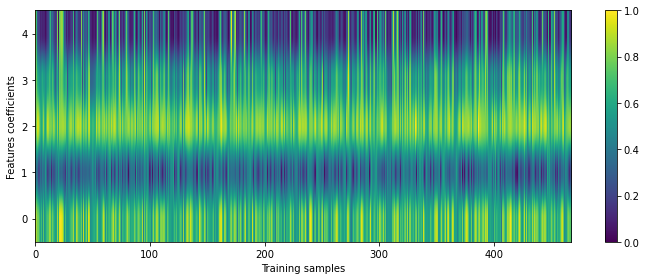

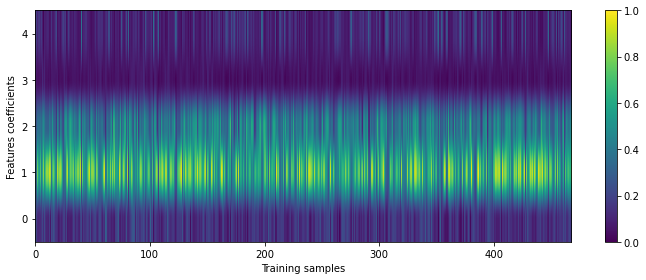

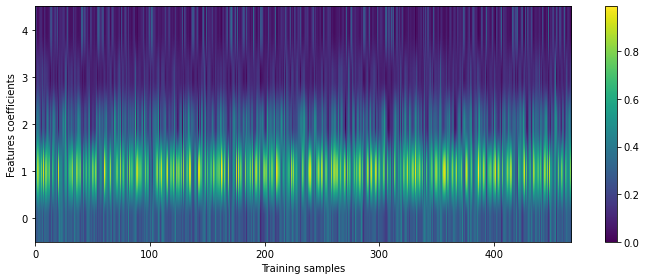

In [ ]:
# PLOT DELLE FEAUTURES DEL TRAINING
classes = ['Distortion', 'NoFX', 'Tremolo']
for i in classes:
    the_features = dict_train_features[i].transpose()
    # Visualization
    fig = plt.figure(figsize=(10, 4))
    #plt.subplot(1,2,1)
    plt.imshow(the_features, origin='lower', aspect='auto')
    plt.xlabel('Training samples')
    plt.ylabel('Features coefficients')
    #plt.title('MFCC (coefficients 0 to 13) for class {}'.format(c))
    plt.colorbar()
    plt.tight_layout()


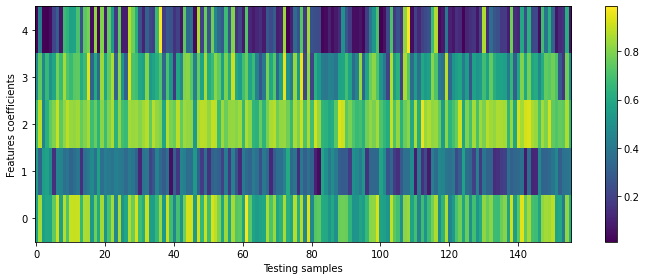

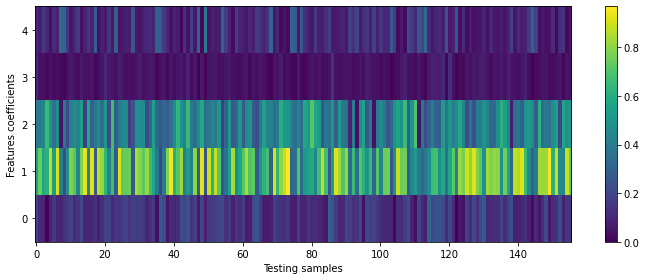

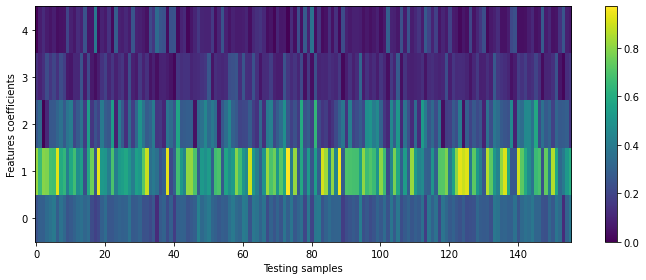

In [ ]:
# PLOT DELLE FEAUTURES MFCC DEL TESTING

classes = ['Distortion', 'NoFX', 'Tremolo']
for c in classes:
    the_features = dict_test_features[c].transpose()
    # Visualization
    fig = plt.figure(figsize=(10, 4))
    #plt.subplot(1,2,1)
    plt.imshow(the_features, origin='lower', aspect='auto')
    plt.xlabel('Testing samples')
    plt.ylabel('Features coefficients')
    #plt.title('MFCC (coefficients 0 to 13) for class {}'.format(c))
    plt.colorbar()
    plt.tight_layout()


# ***SVM***

## **Define SVM models**

In [ ]:
SVM_parameters={
    'C': 1,
    'kernel': 'rbf',
}

#multi-class SVM
clf_01 = sklearn.svm.SVC(**SVM_parameters, probability=True)
clf_02 = sklearn.svm.SVC(**SVM_parameters, probability=True)
clf_12 = sklearn.svm.SVC(**SVM_parameters, probability=True)


In [ ]:
clf_01.fit(np.concatenate((X_train_0_norm, X_train_1_norm), axis=0), 
           np.concatenate((y_train_0, y_train_1), axis=0))
           
clf_02.fit(np.concatenate((X_train_0_norm, X_train_2_norm), axis=0), 
           np.concatenate((y_train_0, y_train_2), axis=0))

clf_12.fit(np.concatenate((X_train_1_norm, X_train_2_norm), axis=0), 
           np.concatenate((y_train_1, y_train_2), axis=0))

SVC(C=1, probability=True)

In [ ]:
y_test_predicted_01 = clf_01.predict(X_test).reshape(-1, 1)
y_test_predicted_02 = clf_02.predict(X_test).reshape(-1, 1)
y_test_predicted_12 = clf_12.predict(X_test).reshape(-1, 1)

majority voting

In [ ]:
y_test_predicted = np.concatenate((y_test_predicted_01, y_test_predicted_02, y_test_predicted_12), axis=1)
y_test_predicted = np.array(y_test_predicted, dtype=np.int)

In [ ]:
y_test_predicted_mv = np.zeros((y_test_predicted.shape[0],))
for i, e in enumerate(y_test_predicted):
    y_test_predicted_mv[i] = np.bincount(e).argmax() 

## SVM Confusion Matrix 

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

              precision    recall  f1-score   support

  Distortion       1.00      1.00      1.00       156
        NoFX       0.96      0.90      0.93       156
     Tremolo       0.91      0.96      0.93       156

    accuracy                           0.96       468
   macro avg       0.96      0.96      0.96       468
weighted avg       0.96      0.96      0.96       468



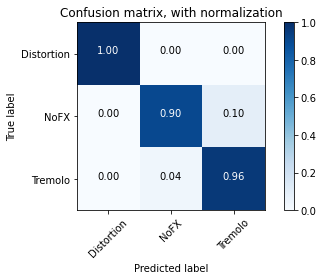

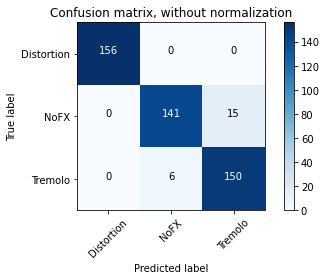

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_test_predicted_mv, labels=[0, 1, 2])
np.set_printoptions(precision=2)
labels = ['Distortion', 'NoFX', 'Tremolo']

#Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labels, normalize=True,
                      title='Confusion matrix, with normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labels, normalize=False,
                      title='Confusion matrix, without normalization')


print(classification_report(y_test, y_test_predicted_mv, target_names=labels ))

# ***NEURAL NETWORK***

## **Define neural network models**

In [ ]:
model = models.Sequential()

#input layer with 256 neurons and input shape = number of features 
model.add(layers.Dense(256, activation='relu', input_shape=(X_train_new.shape[1],))) 

#hidden layers with 128 and 64 neurons 
model.add(layers.Dense(128, activation='relu')) #relu applies the rectified linear unit activation function
model.add(layers.Dense(64, activation='relu'))

#output layer (3 classes)
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam', #deep learning optimization algorithm
              loss='sparse_categorical_crossentropy', #to evaluate the network efficiency
              metrics=['accuracy']) #accuracy is a metric to be evaluated

In [ ]:
history = model.fit(X_train_new,
                    y_train,
                    epochs=120,
                    batch_size=128)

Epoch 1/120
11/11 [==============================] - 0s 2ms/step - loss: 0.9940 - accuracy: 0.8412
Epoch 2/120
11/11 [==============================] - 0s 2ms/step - loss: 0.7542 - accuracy: 0.9074
Epoch 3/120
11/11 [==============================] - 0s 2ms/step - loss: 0.5073 - accuracy: 0.9067
Epoch 4/120
11/11 [==============================] - 0s 2ms/step - loss: 0.3389 - accuracy: 0.9238
Epoch 5/120
11/11 [==============================] - 0s 2ms/step - loss: 0.2384 - accuracy: 0.9238
Epoch 6/120
11/11 [==============================] - 0s 2ms/step - loss: 0.1946 - accuracy: 0.9302
Epoch 7/120
11/11 [==============================] - 0s 2ms/step - loss: 0.1794 - accuracy: 0.9295
Epoch 8/120
11/11 [==============================] - 0s 2ms/step - loss: 0.1681 - accuracy: 0.9309
Epoch 9/120
11/11 [==============================] - 0s 2ms/step - loss: 0.1659 - accuracy: 0.9338
Epoch 10/120
11/11 [==============================] - 0s 2ms/step - loss: 0.1639 - accuracy: 0.9266
Epoch 11/

11/11 [==============================] - 0s 3ms/step - loss: 0.0864 - accuracy: 0.9644
Epoch 83/120
11/11 [==============================] - 0s 4ms/step - loss: 0.0892 - accuracy: 0.9630
Epoch 84/120
11/11 [==============================] - 0s 3ms/step - loss: 0.1095 - accuracy: 0.9587
Epoch 85/120
11/11 [==============================] - 0s 3ms/step - loss: 0.0963 - accuracy: 0.9587
Epoch 86/120
11/11 [==============================] - 0s 3ms/step - loss: 0.0865 - accuracy: 0.9672
Epoch 87/120
11/11 [==============================] - 0s 3ms/step - loss: 0.0891 - accuracy: 0.9630
Epoch 88/120
11/11 [==============================] - 0s 3ms/step - loss: 0.0905 - accuracy: 0.9672
Epoch 89/120
11/11 [==============================] - 0s 3ms/step - loss: 0.0882 - accuracy: 0.9615
Epoch 90/120
11/11 [==============================] - 0s 4ms/step - loss: 0.0856 - accuracy: 0.9672
Epoch 91/120
11/11 [==============================] - 0s 3ms/step - loss: 0.0843 - accuracy: 0.9651
Epoch 92/120


In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test_acc: ',test_acc)

15/15 [==============================] - 0s 1ms/step - loss: 0.0984 - accuracy: 0.9615
test_acc:  0.9615384340286255


              precision    recall  f1-score   support

  Distortion       1.00      1.00      1.00       156
        NoFX       0.96      0.92      0.94       156
     Tremolo       0.93      0.96      0.94       156

    accuracy                           0.96       468
   macro avg       0.96      0.96      0.96       468
weighted avg       0.96      0.96      0.96       468



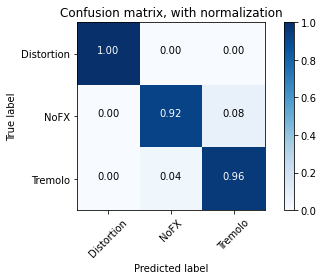

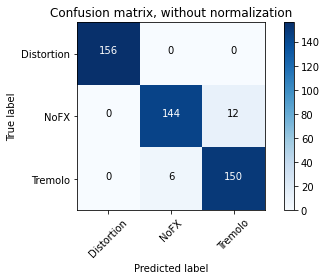

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)

cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
np.set_printoptions(precision=2)
labels = ['Distortion', 'NoFX', 'Tremolo']

#Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labels, normalize=True,
                      title='Confusion matrix, with normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labels, normalize=False,
                      title='Confusion matrix, without normalization')


print(classification_report(y_test, y_pred, target_names=labels ))
